In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

In [2]:
df = pd.read_csv("time_series_data.csv")
df_test = pd.read_csv("time_series_data_AL.csv")
df_train = df[df["Year"] <= 2023]
numerical_cols = ["sin_month", "cos_month", "Year", "Month", "num_days", "holiday_num"]
numerical_features = [
    "crime_count",
    "crime_pct_change",
    "morning",
    "afternoon",
    "evening",
    "night"
]
for i in [1, 2, 3, 6, 12]:
    for j in numerical_features:
        numerical_cols.append(f"{j}_lag{i}")
for i in [3, 6]:
    for j in numerical_features:
        numerical_cols.append(f"{j}_ma{i}")

X_train = df_train[numerical_cols]
y_train = df_train["crime_count"]
X_test = df_test[numerical_cols]
y_test = df_test["crime_count"]

In [3]:
cat_pipe = Pipeline([
    ("encoder", OneHotEncoder(handle_unknown="ignore")),
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_cols)
    ]
)

model = Pipeline(
    steps=[("preprocessor", preprocessor), ("regressor", LinearRegression())],
)

model.fit(X_train, y_train)

lr_train_pred = model.predict(X_train)
lr_pred = model.predict(X_test)
lr_train_pred = np.round(lr_train_pred)
lr_pred = np.round(lr_pred)

preprocessor_tree = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numerical_cols),
    ]
)

In [4]:
xg_model = Pipeline(
    steps=[
        ("preprocessor", preprocessor_tree),
        (
            "regressor",
            XGBRegressor(
                n_estimators=200,
                learning_rate=0.1,
                max_depth=5,
                min_child_weight=7,
                gamma=0.1,
                random_state=42,
            ),
        ),
    ]
)

xg_model.fit(X_train, y_train)
xg_train_pred = xg_model.predict(X_train)
xg_pred = xg_model.predict(X_test)
xg_train_pred = np.round(xg_train_pred)
xg_pred = np.round(xg_pred)

In [5]:
xg_rmse = mean_squared_error(y_test, xg_pred)
xg_mae = mean_absolute_error(y_test, xg_pred)
xg_r2 = r2_score(y_test, xg_pred)
xg_mae_percentage = (xg_mae / y_test.mean()) * 100
print(f"XGBoost Results:")
print(f"Mean Squared Error: {xg_rmse:.2f}")
print(f"Mean Absolute Error: {xg_mae:.2f}")
print(f"R² Score: {xg_r2:.2f}")
print(f"Normalized Mean Absolute Error Percentage: {xg_mae_percentage:.2f}%")

XGBoost Results:
Mean Squared Error: 80388.70
Mean Absolute Error: 94.55
R² Score: 0.96
Normalized Mean Absolute Error Percentage: 20.71%


In [6]:
param_grid = {
    "regressor__n_estimators": [200],
    "regressor__learning_rate": [0.1],
    "regressor__max_depth": [5],
    "regressor__min_child_weight": [5],
    "regressor__gamma": [0.1],
}

xg_model = Pipeline(
    steps=[("preprocessor", preprocessor), ("regressor", XGBRegressor(random_state=42))]
)

grid_search = GridSearchCV(
    estimator=xg_model,
    param_grid=param_grid,
    cv=5,  
    scoring="neg_mean_squared_error",
    n_jobs=-1,  
    verbose=1,  
)

In [16]:
df_test_result = df_test.copy()
df_lstm = pd.read_csv("lstm_predictions.csv")
df_cnn = pd.read_csv("cnn_predictions.csv")
df_lstm = df_lstm[["location_id", "crime_count", "lstm_pred", "time_id"]]
df_cnn = df_cnn[["location_id", "time_id", "cnn_pred", "Year"]]

df_test_result = df_test_result.merge(
    df_lstm[["location_id", "time_id", "lstm_pred"]],
    on=["location_id", "time_id"],
    how="left",
)

df_test_result = df_test_result.merge(
    df_cnn[["location_id", "time_id", "cnn_pred"]],
    on=["location_id", "time_id"],
    how="left",
)

In [21]:
df_test_result["lr_pred"] = lr_pred
df_test_result["xg_pred"] = xg_pred
df_test_result["lstm_pred"] = df_test_result["lstm_pred"]
df_test_result["lr_res"] = df_test_result["crime_count"] - df_test_result["lr_pred"]
df_test_result["xg_res"] = df_test_result["crime_count"] - df_test_result["xg_pred"]
df_test_result["lstm_res"] = df_test_result["crime_count"] - df_test_result["lstm_pred"]
df_test_result[
    ["time_id", "location_id", "crime_count", "xg_pred", "lr_pred"]
]
df_test_result["cnn_res"] = df_test_result["crime_count"] - df_test_result["cnn_pred"]

In [22]:
# summarize the results (metrics)
def summarize_results(df, model):
    df = df.dropna(subset=["crime_count", model])
    rmse = mean_squared_error(df["crime_count"], df[model])
    mae = mean_absolute_error(df["crime_count"], df[model])
    r2 = r2_score(df["crime_count"], df[model])
    mean_value = df["crime_count"].mean()
    mae_percentage = (mae / mean_value) * 100
    return rmse, mae, r2, mae_percentage

for m in ["lr", "xg", "lstm", "cnn"]:
    rmse, mae, r2, mae_percentage = summarize_results(df_test_result, f"{m}_pred")
    print(f"Model: {m}")
    print(f"RMSE\tR²\tMAE\tMAE Percentage")
    print(f"{rmse:.2f}\t{r2:.2f}\t{mae:.2f}\t{mae_percentage:.2f}%")
    print("\n")

Model: lr
RMSE	R²	MAE	MAE Percentage
380492.34	0.79	94.61	20.72%


Model: xg
RMSE	R²	MAE	MAE Percentage
80388.70	0.96	94.55	20.71%


Model: lstm
RMSE	R²	MAE	MAE Percentage
73673.74	0.97	97.67	19.96%


Model: cnn
RMSE	R²	MAE	MAE Percentage
290572.70	0.84	250.08	54.77%




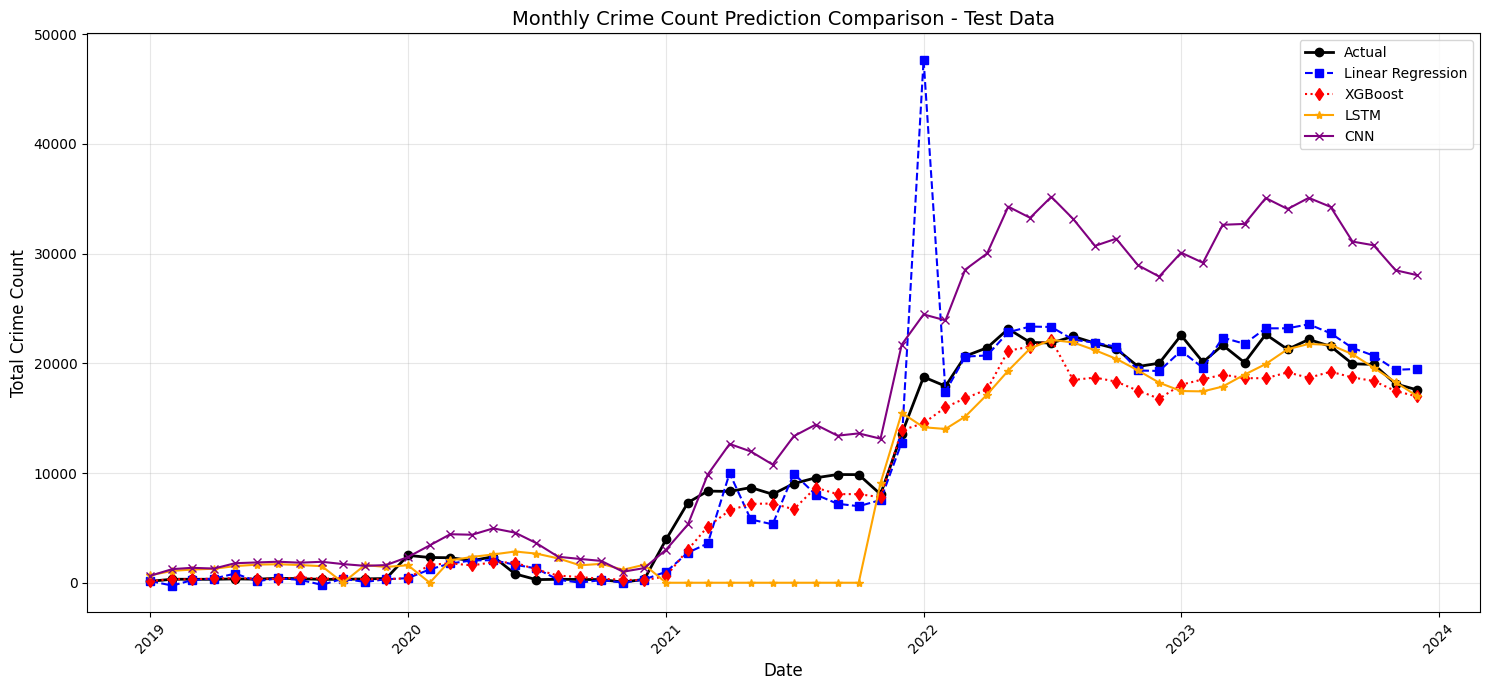

In [27]:
monthly_test = (
    df_test_result.groupby(["Year", "Month"])
    .agg(
        {
            "crime_count": "sum",
            "lr_pred": "sum",
            "xg_pred": "sum",
            "lstm_pred": "sum",
            "cnn_pred": "sum",  # Added CNN predictions
        }
    )
    .reset_index()
)

monthly_test["date"] = pd.to_datetime(
    monthly_test["Year"].astype(str) + "-" + monthly_test["Month"].astype(str) + "-01"
)

monthly_test = monthly_test.sort_values("date")

y_test_monthly = monthly_test["crime_count"]

# Plot monthly comparison - Test data
plt.figure(figsize=(15, 7))
plt.plot(
    monthly_test["date"],
    monthly_test["crime_count"],
    marker="o",
    linewidth=2,
    label="Actual",
    color="black",
)
plt.plot(
    monthly_test["date"],
    monthly_test["lr_pred"],
    marker="s",
    linestyle="--",
    label="Linear Regression",
    color="blue",
)
plt.plot(
    monthly_test["date"],
    monthly_test["xg_pred"],
    marker="d",
    linestyle=":",
    label="XGBoost",
    color="red",
)
plt.plot(
    monthly_test["date"],
    monthly_test["lstm_pred"],
    marker="*",
    linestyle="-",
    label="LSTM",
    color="orange",
)
plt.plot(
    monthly_test["date"],
    monthly_test["cnn_pred"],
    marker="x", 
    linestyle="-",
    label="CNN",
    color="purple",  
)
plt.title("Monthly Crime Count Prediction Comparison - Test Data", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Total Crime Count", fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("monthly_comparison_test_data_with_cnn.pdf", format="pdf")
plt.show()

In [28]:
for m in ["lr", "xg", "lstm", "cnn"]:
    rmse, mae, r2, mae_percentage = summarize_results(monthly_test, f"{m}_pred")
    print(f"Model: {m}")
    print(f"RMSE\tR²\tMAE\tMAE Percentage")
    print(f"{rmse:.2f}\t{r2:.2f}\t{mae:.2f}\t{mae_percentage:.2f}%")
    print("\n")

Model: lr
RMSE	R²	MAE	MAE Percentage
16049199.18	0.81	1457.12	14.08%


Model: xg
RMSE	R²	MAE	MAE Percentage
4101011.73	0.95	1470.43	14.21%


Model: lstm
RMSE	R²	MAE	MAE Percentage
15372495.70	0.81	2640.03	25.51%


Model: cnn
RMSE	R²	MAE	MAE Percentage
48025136.19	0.42	5448.37	52.64%




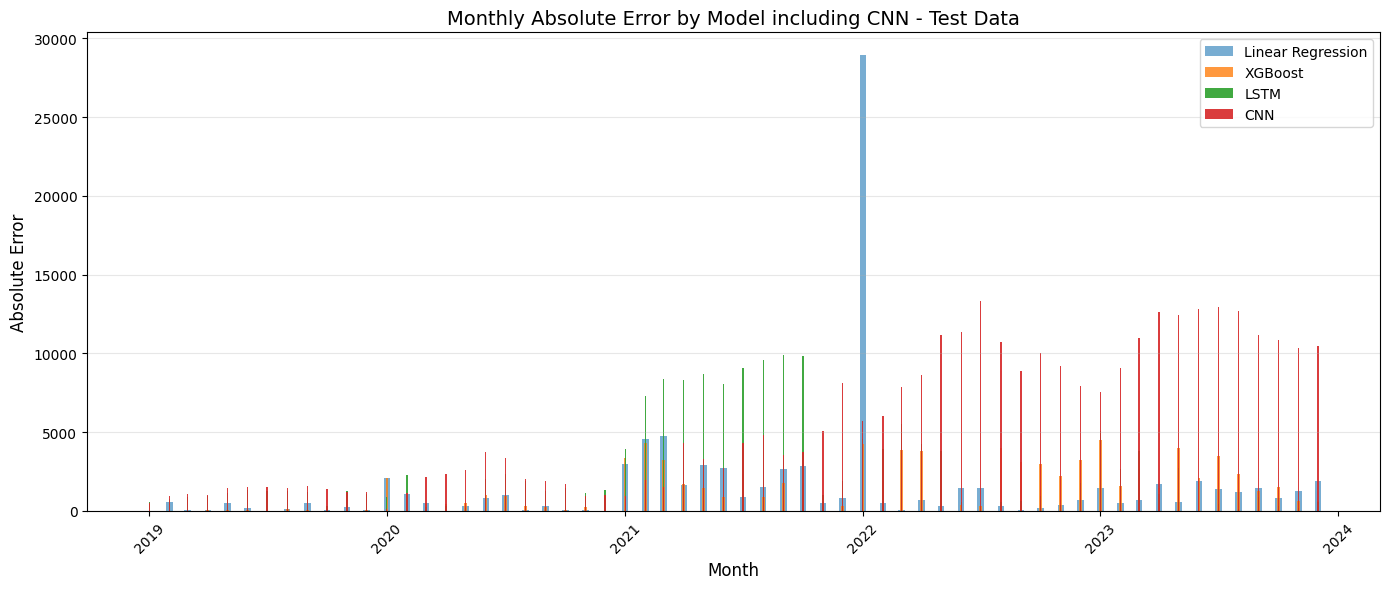

In [29]:
# Calculate monthly MAE for each model (test data)
monthly_test["lr_mae"] = abs(monthly_test["crime_count"] - monthly_test["lr_pred"])
monthly_test["xg_mae"] = abs(monthly_test["crime_count"] - monthly_test["xg_pred"])
monthly_test["lstm_mae"] = abs(monthly_test["crime_count"] - monthly_test["lstm_pred"])
monthly_test["cnn_mae"] = abs(monthly_test["crime_count"] - monthly_test["cnn_pred"])  # Add CNN MAE

# Plot MAE by month
plt.figure(figsize=(14, 6))
plt.bar(
    monthly_test["date"],
    monthly_test["lr_mae"],
    width=10,
    alpha=0.6,
    label="Linear Regression",
)
plt.bar(
    monthly_test["date"],
    monthly_test["xg_mae"],
    width=4,
    alpha=0.8,
    label="XGBoost",
)
plt.bar(
    monthly_test["date"],
    monthly_test["lstm_mae"],
    width=2,
    alpha=0.9,
    label="LSTM",
)
plt.bar(
    monthly_test["date"],
    monthly_test["cnn_mae"],
    width=2,
    alpha=0.9,
    label="CNN",  
)
plt.title("Monthly Absolute Error by Model including CNN - Test Data", fontsize=14)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Absolute Error", fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3, axis="y")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("monthly_absolute_error_by_model_with_cnn_test_data.pdf", format="pdf")
plt.show()

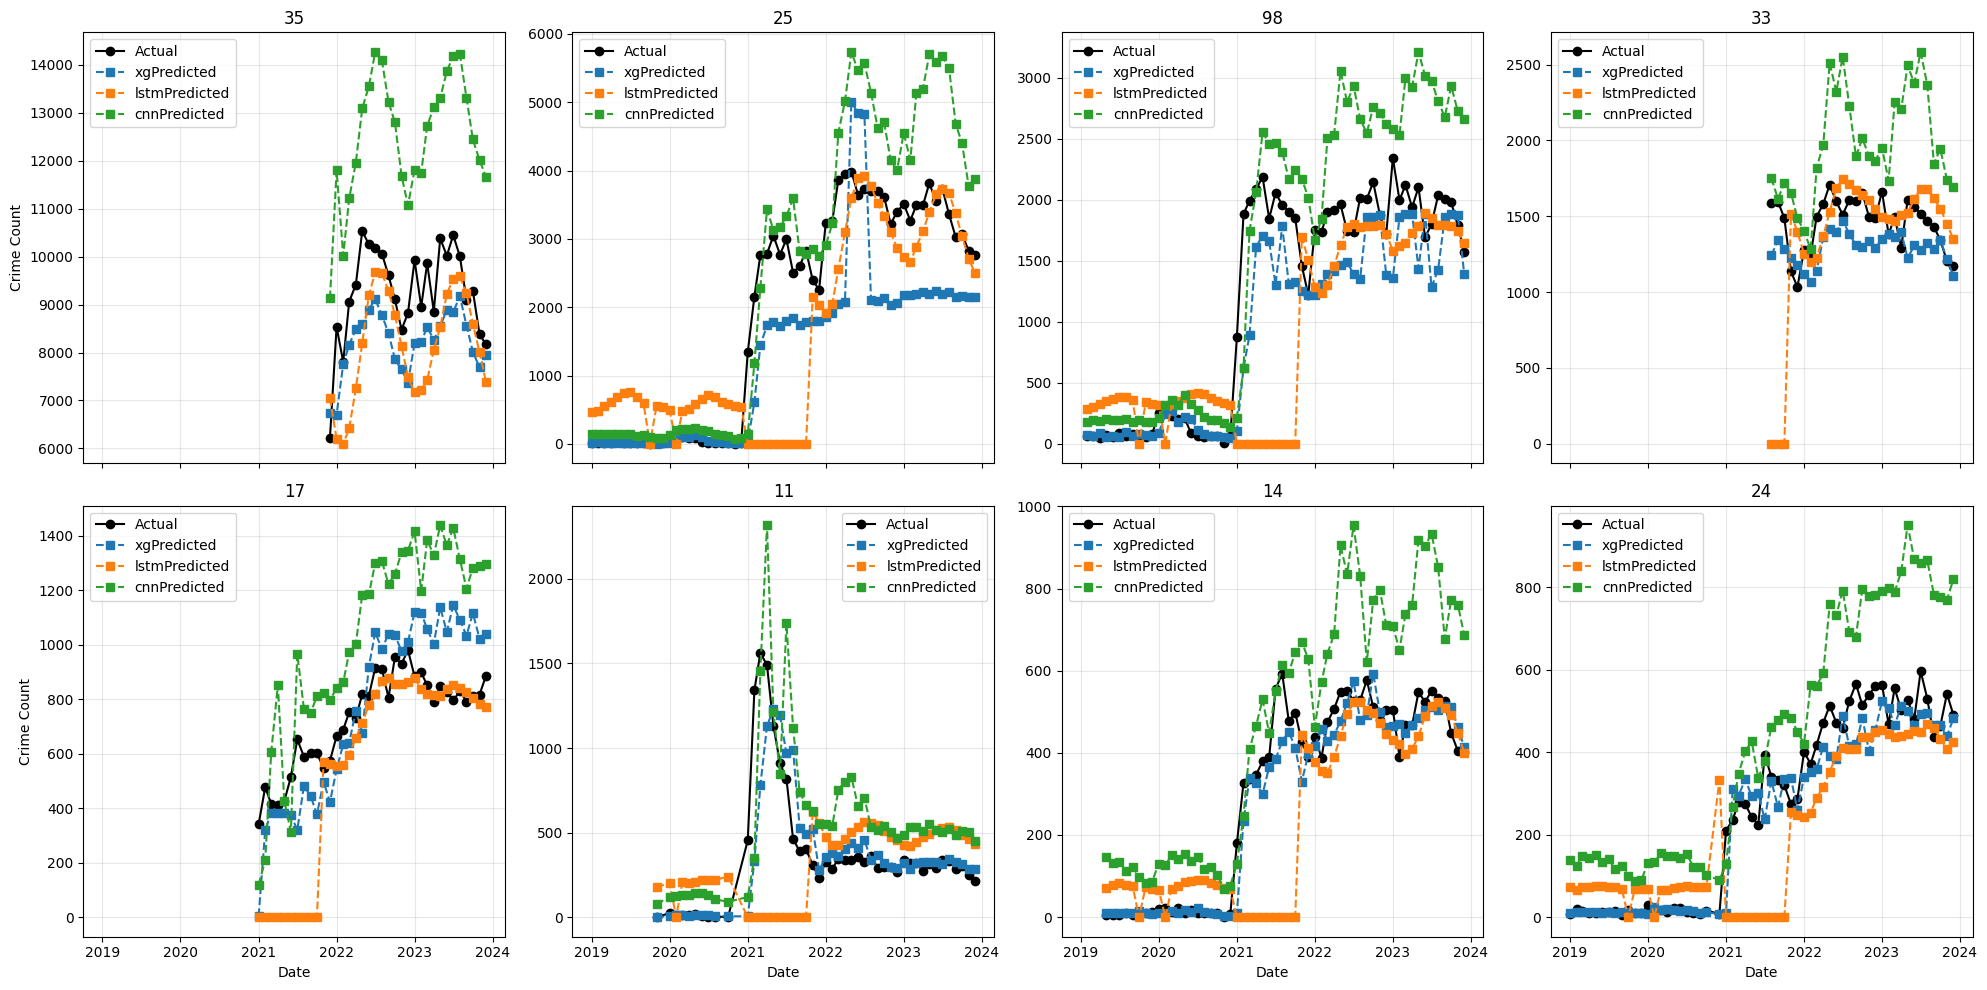

In [36]:
# 1. Identify the top 8 locations by total crime count
top8_locations = (
    df_test_result.groupby("location_id")["crime_count"]
    .sum()
    .nlargest(8)
    .index.tolist()
)

# 2. Filter data for these top 8 locations
df_top8 = df_test_result[df_test_result["location_id"].isin(top8_locations)].copy()

# 3. Aggregate monthly data (summing the actual and predicted counts)
df_trend = df_top8.groupby(["location_id", "Year", "Month"], as_index=False).agg(
    crime_count=("crime_count", "sum"),
    xg_pred=("xg_pred", "sum"),
    lr_pred=("lr_pred", "sum"),
    lstm_pred=("lstm_pred", "sum"),
    cnn_pred=("cnn_pred", "sum"),
)

# 4. Create a datetime column for proper time series plotting (using the 1st day of each month)
df_trend["Date"] = pd.to_datetime(
    df_trend["Year"].astype(str) + "-" + df_trend["Month"].astype(str) + "-01"
)

# 5. Plotting in subplots (2 rows x 4 columns for 8 subplots) without sharing the y-axis
fig, axes = plt.subplots(
    nrows=2, ncols=4, figsize=(20, 10), sharex=True
)  # Remove sharey to allow independent y-axis
axes = axes.flatten()  # Flatten to iterate easily

for i, loc in enumerate(top8_locations):
    ax = axes[i]
    df_loc = df_trend[df_trend["location_id"] == loc].sort_values("Date")

    # Plot actual crime count
    ax.plot(
        df_loc["Date"],
        df_loc["crime_count"],
        marker="o",
        linestyle="-",
        label="Actual",
        color="black",
    )
    # Plot predicted crime count
    for m in ["xg", "lstm", "cnn"]:
        ax.plot(
            df_loc["Date"],
            df_loc[f"{m}_pred"],
            marker="s",
            linestyle="--",
            label=f"{m}Predicted",
        )

    ax.set_title(loc)
    ax.grid(True, alpha=0.3)

    # Set labels for the leftmost and bottom plots only
    if i % 4 == 0:  # Leftmost plots
        ax.set_ylabel("Crime Count")
    if i >= 4:  # Bottom row plots
        ax.set_xlabel("Date")

    ax.legend()

# Remove any unused subplots (if there are fewer than 8, not applicable here)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig("monthly_crime_trends_top8_locations_test_data.pdf", format="pdf")
plt.show()

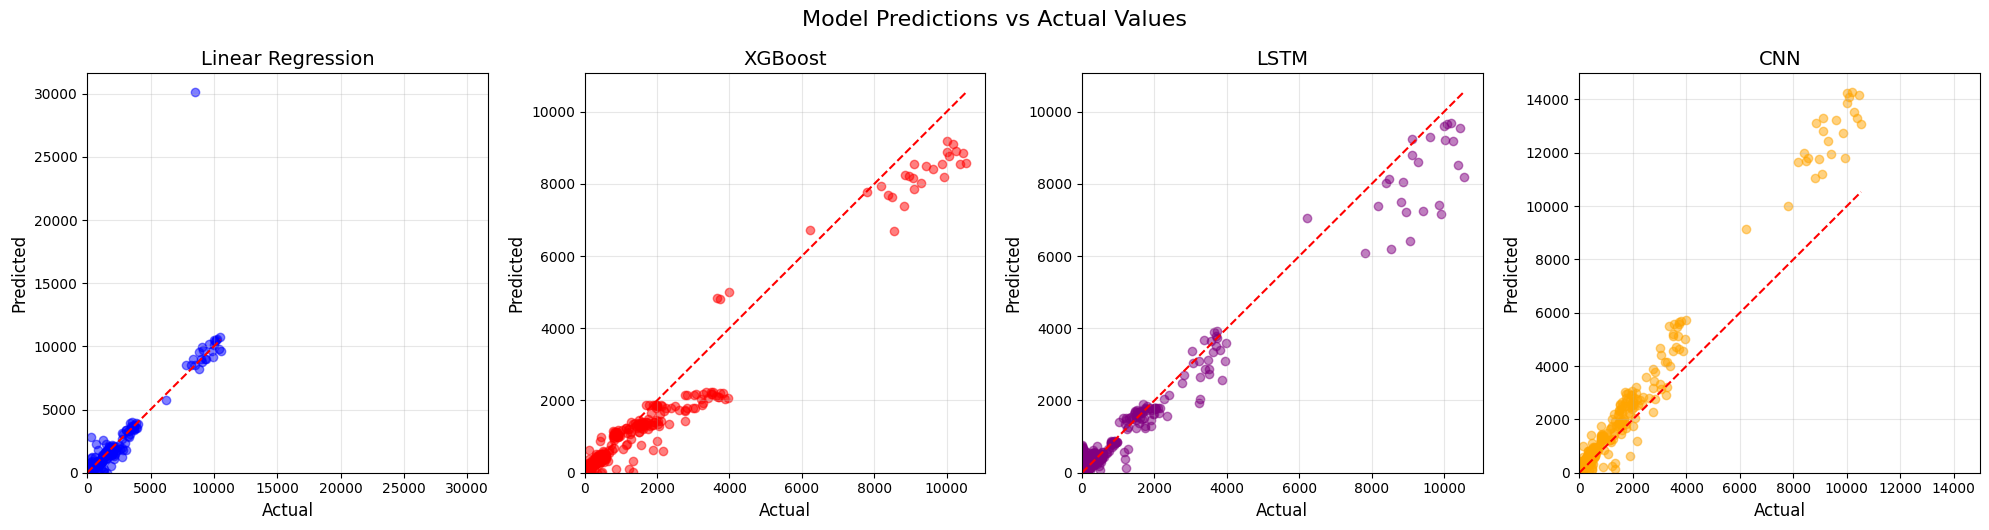

In [35]:
# Define models, colors, and titles 
models = ["lr_pred", "xg_pred", "lstm_pred", "cnn_pred"]
colors = ["blue", "red", "purple", "orange"]
titles = ["Linear Regression", "XGBoost", "LSTM", "CNN"]

# Create subplots (1 row, 5 columns)
fig, axes = plt.subplots(1, 4, figsize=(20, 5))  # Adjust size as needed

# Loop through each model and create scatter plot
for i, (model, color, title) in enumerate(zip(models, colors, titles)):
    # Create scatter plot
    axes[i].scatter(
        df_test_result["crime_count"], df_test_result[model], alpha=0.5, color=color
    )

    # Add diagonal line for perfect predictions
    axes[i].plot(
        [0, df_test_result["crime_count"].max()],
        [0, df_test_result["crime_count"].max()],
        "r--",
    )

    # Add title and labels
    axes[i].set_title(title, fontsize=14)
    axes[i].set_xlabel("Actual", fontsize=12)
    axes[i].set_ylabel("Predicted", fontsize=12)
    axes[i].grid(True, alpha=0.3)

    # Optional: Set the same limits for all plots for easier comparison
    max_val = max(df_test_result["crime_count"].max(), df_test_result[model].max())
    axes[i].set_xlim(0, max_val * 1.05)
    axes[i].set_ylim(0, max_val * 1.05)

# Adjust layout
plt.tight_layout()
plt.suptitle("Model Predictions vs Actual Values", fontsize=16, y=1.05)
plt.savefig("model_predictions_vs_actual_values_test_data.pdf", format="pdf")
plt.show()